# Import library 

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.2 MB/s eta 0:00:00


# Load dataset

In [2]:
#Change data path accordingly

train_path = 'propaganda_train.tsv'
val_path = 'propaganda_val.tsv'

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_dataset(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, skiprows=1, names=['label', 'sentence'])
    
    sentences = data['sentence'].tolist()
    labels = data['label'].tolist()

    return sentences, labels

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

X_train, y_train = load_dataset(train_path)

# Filter out data with label 'not_propaganda'
X_train = [x for x, y in zip(X_train, y_train) if y != 'not_propaganda']
y_train = [y for y in y_train if y != 'not_propaganda']

y_train = label_encoder.fit_transform(y_train)

# Splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_test, y_test = load_dataset(val_path)

# Filter out data with label 'not_propaganda'
X_test = [x for x, y in zip(X_test, y_test) if y != 'not_propaganda']
y_test = [y for y in y_test if y != 'not_propaganda']

y_test = label_encoder.transform(y_test)

# Get the label to int mapping
label_to_int = {label: idx for idx, label in enumerate(label_encoder.classes_)}
int_to_label = {idx: label for label, idx in label_to_int.items()}


In [4]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Analysis of the dataset

In [ ]:
print(X_train[0:10])
print(len(X_train))

['<BOS> This tragedy could have been prevented if San Francisco had simply turned the alien over to ICE as we requested, instead of releasing him back onto the streets, <EOS> ICE Director Thomas Homan said in a statement on Thursday. ', '<BOS> Whatever corroboration Ms. Ford was hoping for from “witnesses” she claimed were at the alleged party is non-existent <EOS>. ', "The answer is that <BOS> this is all a ruse to block Judge Kavanaugh's confirmation by all means necessary <EOS>. ", 'The text messages are expected to take longer because of the <BOS> sheer number <EOS> involved and the fact that Trump ordered their release without redactions. ', 'Looking back and carefully examining his record, Jorge Bergoglio’s <BOS> mastery <EOS> of using the weaknesses of morally compromised men is becoming evident. ', 'Nation of Islam leader and prominent antisemite Louis Farrakhan chanted “Death to America” and claimed that “<BOS> America has never been a democracy <EOS>” on Sunday during a solid

In [ ]:
print(y_train[0:10])
print(len(y_train))

[1 2 1 3 5 2 1 6 1 3]
1100


In [ ]:
label_counts = {label: 0 for label in label_to_int.values()}

for label in y_train:
    label_counts[label] += 1

for label, count in label_counts.items():
    print(f"There are {count} instances of class {int_to_label[label]}")

There are 136 instances of class appeal_to_fear_prejudice
There are 142 instances of class causal_oversimplification
There are 133 instances of class doubt
There are 150 instances of class exaggeration,minimisation
There are 137 instances of class flag_waving
There are 138 instances of class loaded_language
There are 137 instances of class name_calling,labeling
There are 127 instances of class repetition


In [ ]:
unique_words = set()
for sentence in X_train:
    for word in sentence.split():
        unique_words.add(word.lower())
print(f"Number of unique words in X_train: {len(unique_words)}")

Number of unique words in X_train: 7966


Token indices sequence length is longer than the specified maximum sequence length for this model (1942 > 512). Running this sequence through the model will result in indexing errors


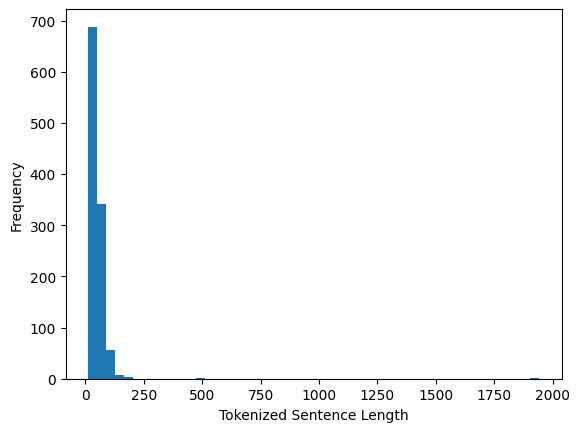

Mean length: 50.78818181818182
Median length: 43
90th percentile length: 80
95th percentile length: 94
99th percentile length: 140


In [ ]:
import matplotlib.pyplot as plt

def analyze_sentence_lengths(sentences, tokenizer):
    tokenized_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences]
    plt.hist(tokenized_lengths, bins=50)
    plt.xlabel('Tokenized Sentence Length')
    plt.ylabel('Frequency')
    plt.show()

    mean_length = sum(tokenized_lengths) / len(tokenized_lengths)
    median_length = sorted(tokenized_lengths)[len(tokenized_lengths) // 2]
    percentile_90 = sorted(tokenized_lengths)[int(0.9 * len(tokenized_lengths))]
    percentile_95 = sorted(tokenized_lengths)[int(0.95 * len(tokenized_lengths))]
    percentile_99 = sorted(tokenized_lengths)[int(0.99 * len(tokenized_lengths))]

    print(f'Mean length: {mean_length}')
    print(f'Median length: {median_length}')
    print(f'90th percentile length: {percentile_90}')
    print(f'95th percentile length: {percentile_95}')
    print(f'99th percentile length: {percentile_99}')


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
analyze_sentence_lengths(X_train, tokenizer)

# Pre-trained Bert model approach

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 140
batch_size = 32

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Baseline

In [ ]:
from torch import nn
from transformers import BertModel, AutoConfig

class BertClassifier(nn.Module):
    
    def __init__(self, pretrained_model='bert-base-uncased', dropout=0.5, num_classes=8):
        
        super(BertClassifier, self).__init__()
        
        config = AutoConfig.from_pretrained(pretrained_model)
        self.bert = BertModel.from_pretrained(pretrained_model, config=config)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(config.hidden_size, num_classes)
        
    def forward(self, input_id, mask):
        
        last_hidden_layer, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        final_layer = self.linear(dropout_output)
        
        return final_layer








In [ ]:
model = BertClassifier(pretrained_model='bert-base-uncased', dropout=0.1, num_classes=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-15-728381c6b88b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

patience = 3
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(10):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted', zero_division=1)
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

Epoch: 1, Validation F1: 0.19868797308662745
Epoch: 2, Validation F1: 0.1852169860644802
Epoch: 3, Validation F1: 0.2173450062401763
Epoch: 4, Validation F1: 0.22166580699333743
Epoch: 5, Validation F1: 0.21644488206966853
Epoch: 6, Validation F1: 0.21761755558503526
Epoch: 7, Validation F1: 0.2389737898248147
Epoch: 8, Validation F1: 0.22103388044154593
Epoch: 9, Validation F1: 0.24488059235319756
Epoch: 10, Validation F1: 0.23209196754273154
Accuracy: 0.25089605734767023
Precision: 0.25886310855321365
Recall: 0.25089605734767023
F1-score: 0.22648052938326066


## Hyper-parameter tuning

In [ ]:
from sklearn.metrics import f1_score

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

def grid_search(X_train, y_train, X_val, y_val, tokenizer, max_length):
    best_result = None
    best_f1 = float('-inf')

    learning_rates = [1e-5,1e-6,1e-7]
    batch_sizes = [32, 64]
    patience = 3
    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]

    total_combinations = len(learning_rates) * len(batch_sizes) * len(dropouts) * len(weight_decays)
    current_combination = 0

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    for lr in learning_rates:
        for bs in batch_sizes:
            for do in dropouts:
                for wd in weight_decays:
                    current_combination += 1
                    # Create a model with the current hyperparameters
                    model = BertClassifier(dropout=do).to(device)

                    # Create dataloaders
                    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
                    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
                    val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

                    # Train the model
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
                    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold=1e-3, verbose=False)

                    early_stopping_counter = 0
                    best_val_f1 = -float('inf')

                    for epoch in range(10):
                        model.train()
                        for batch in train_dataloader:
                            input_ids = batch['input_ids'].to(device)
                            attention_mask = batch['attention_mask'].to(device)
                            labels = batch['label'].to(device)

                            optimizer.zero_grad()
                            outputs = model(input_ids, attention_mask)
                            loss = loss_fn(outputs, labels)
                            loss.backward()
                            optimizer.step()

                        # Evaluate the model
                        model.eval()
                        val_predictions = []
                        val_labels = []

                        with torch.no_grad():
                            for batch in val_dataloader:
                                input_ids = batch['input_ids'].to(device)
                                attention_mask = batch['attention_mask'].to(device)
                                labels = batch['label'].to(device)

                                outputs = model(input_ids, attention_mask)
                                predictions = torch.argmax(outputs, dim=1)

                                val_predictions.extend(predictions.cpu().numpy())
                                val_labels.extend(labels.cpu().numpy())

                        precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            early_stopping_counter = 0
                        else:
                            early_stopping_counter += 1

                        if val_f1 > best_f1:
                            best_f1 = val_f1
                            best_result = {
                                'learning_rate': lr,
                                'batch_size': bs,
                                'dropout': do,
                                'weight_decay': wd,
                                'f1_score': best_f1
                            }

                        if early_stopping_counter >= patience:
                            progress = current_combination / total_combinations
                            print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                            break

                        scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, tokenizer, max_length)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 1.85% | 1/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.1, 'weight_decay': 0.01, 'f1_score': 0.28737891710046465}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 27.78% | 15/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 31.48% | 17/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 35.19% | 19/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 42.59% | 23/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 46.30% | 25/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 50.00% | 27/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 51.85% | 28/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 53.70% | 29/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 57.41% | 31/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 68.52% | 37/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 70.37% | 38/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 72.22% | 39/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 74.07% | 40/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 75.93% | 41/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 77.78% | 42/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 79.63% | 43/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 81.48% | 44/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 83.33% | 45/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 85.19% | 46/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 87.04% | 47/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 88.89% | 48/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 90.74% | 49/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 92.59% | 50/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.de

Progress: 96.30% | 52/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 98.15% | 53/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 100.00% | 54/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


In [ ]:
print(result)

{'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001, 'f1_score': 0.4914520939264858}


## Evaluate


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_best_model(X_train, y_train, X_val, y_val, tokenizer, max_length, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    best_lr = best_params['learning_rate']
    best_bs = best_params['batch_size']
    best_dropout = best_params['dropout']
    best_wd = best_params['weight_decay']

    # Create model 
    model = BertClassifier(dropout=best_dropout).to(device)

    # Create dataloaders
    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_bs, shuffle=False)

    # Create optimizer with best learning rate and weight decay
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold=1e-3, verbose=False)

    # Train the model with early stopping
    for epoch in range(10):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on validation set
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= 5:
            break
        
        scheduler.step(val_f1)

    return model

def evaluate_model(model, test_dataloader, int_to_label):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_input_ids.extend(input_ids.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted',zero_division=1)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    display_labels = [int_to_label[i] for i in sorted(int_to_label.keys())]
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)

    class_report = classification_report(all_labels, all_predictions, target_names=display_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

    # Visualize confusion matrix
    plt.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(23,18))
    cm_display.plot(ax=ax)

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]

    return misclassified, correctly_classified

In [ ]:
result = {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.001}
# Train the model with the best parameters
best_model = train_best_model(X_train, y_train, X_val, y_val, tokenizer, max_length, result)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 0.4659
Precision: 0.4488
Recall: 0.4659
F1-score: 0.4480
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.59      0.56      0.57        43
causal_oversimplification       0.42      0.42      0.42        31
                    doubt       0.62      0.61      0.61        38
exaggeration,minimisation       0.45      0.32      0.38        28
              flag_waving       0.52      0.74      0.61        39
          loaded_language       0.21      0.08      0.12        37
    name_calling,labeling       0.41      0.55      0.47        31
               repetition       0.31      0.38      0.34        32

                 accuracy                           0.47       279
                macro avg       0.44      0.46      0.44       279
             weighted avg       0.45      0.47      0.45       279



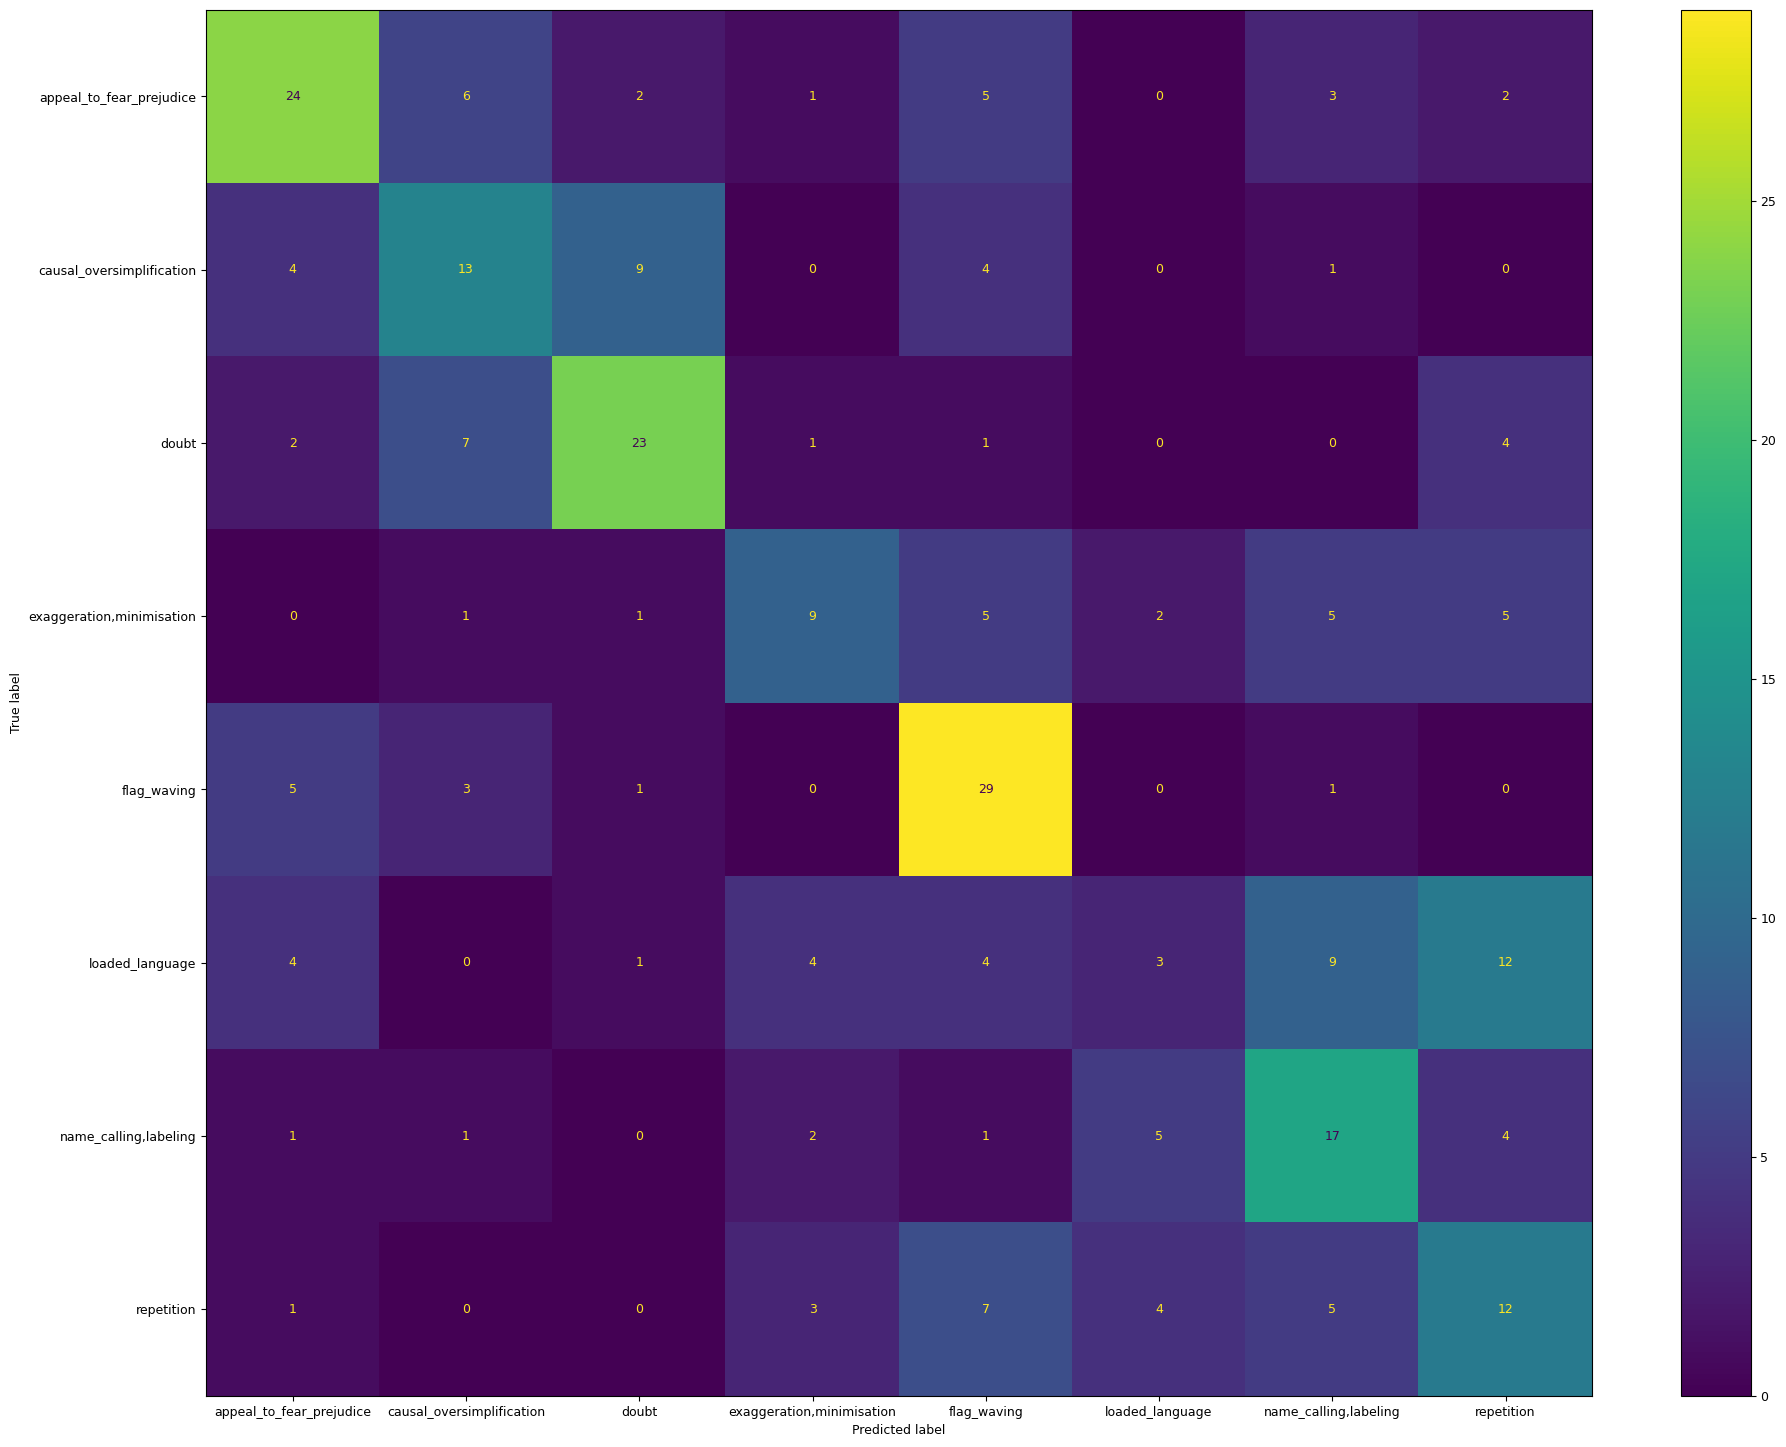

In [ ]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified, correctly_classified = evaluate_model(best_model, test_dataloader, int_to_label)

## Error Analysis


Precision is better for not propaganda whereas recall is better for propaganda. This suggests that the classifier is over-predicting propagada, meaning 

In [ ]:
import pandas as pd

# Decode input_ids back to text
decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in misclassified]

# Extract actual labels and predicted labels
actual_labels = [actual_label for _, actual_label, _ in misclassified]
predicted_labels = [predicted_label for _, _, predicted_label in misclassified]

# Create a dictionary with column names and data
data = {
    "Misclassified Sentence": decoded_sentences,
    "Actual Label": actual_labels,
    "Predicted Label": predicted_labels,
}

# Create a DataFrame using the data
misclassified_df = pd.DataFrame(data)


In [ ]:
misclassified_df.head()

,Misclassified Sentence,Actual Label,Predicted Label
0,mostly because < bos > the country would not l...,1,4
1,lyndon johnson < bos > gets earl warren and se...,0,1
2,it must be exacted from him directly in order ...,7,6
3,is it any wonder that priests and laity alike ...,6,5
4,health workers have been asked to work with co...,5,7


### Sentence length distribution

Test Set - Average Length: 31.95
misclassified - Average Length: 36.30, Maximum Length: 115
Correctly Classified - Average Length: 36.83, Minimum Length: 12


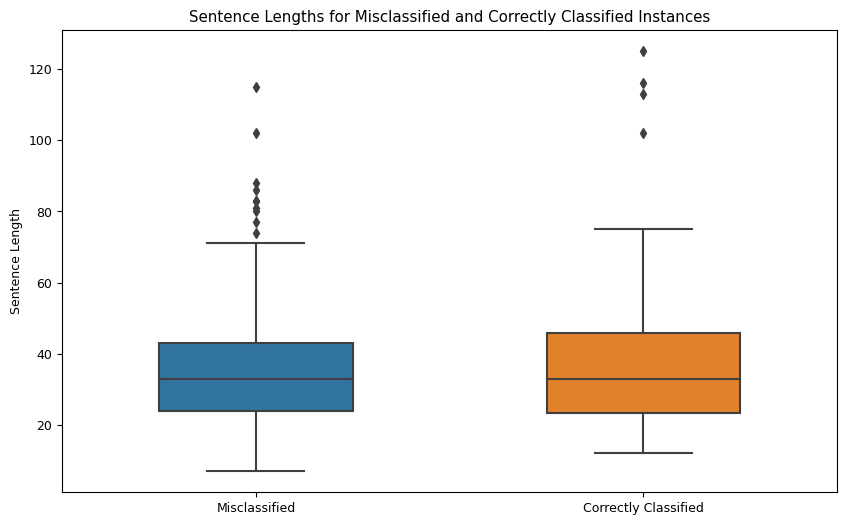

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decode input_ids back to text for misclassified and correctly classified instances
misclassified_decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in misclassified]
correctly_classified_decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]
misclassified_lengths = [len(decoded_sentence.split()) for decoded_sentence in misclassified_decoded_sentences]
correctly_classified_lengths = [len(decoded_sentence.split()) for decoded_sentence in correctly_classified_decoded_sentences]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()



### Most frequent word

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = [tokenizer.convert_ids_to_tokens(input_id) for input_id, _, _ in misclassified]
correctly_classified_sentences = [tokenizer.convert_ids_to_tokens(input_id) for input_id, _, _ in correctly_classified]

# Remove special tokens like '[CLS]', '[SEP]', and '[PAD]'
misclassified_sentences = [" ".join([t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]) for tokens in misclassified_sentences]
correctly_classified_sentences = [" ".join([t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]) for tokens in correctly_classified_sentences]

# Get top 10 most frequent words in both categories and their sentence counts
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

Top 10 words in misclassified sentences with their sentence counts:
e: 154 (in 149 sentences)
bo: 153 (in 149 sentences)
trump: 19 (in 18 sentences)
world: 15 (in 14 sentences)
one: 13 (in 12 sentences)
would: 12 (in 11 sentences)
president: 9 (in 6 sentences)
said: 9 (in 9 sentences)
church: 9 (in 7 sentences)
vi: 8 (in 6 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
bo: 135 (in 130 sentences)
e: 134 (in 129 sentences)
trump: 15 (in 15 sentences)
american: 12 (in 9 sentences)
people: 11 (in 11 sentences)
ass: 10 (in 8 sentences)
would: 10 (in 10 sentences)
public: 9 (in 9 sentences)
said: 9 (in 9 sentences)
us: 9 (in 9 sentences)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Grammarticial sturcture analysis

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_decoded_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_decoded_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
punct: 802
prep: 468
pobj: 455
det: 427
nsubj: 377
amod: 290
dep: 267
dobj: 266
compound: 260
ROOT: 233

Top 10 grammatical constructs in correctly classified sentences:
punct: 739
prep: 402
pobj: 389
det: 373
nsubj: 355
amod: 251
dobj: 244
compound: 222
dep: 217
ROOT: 216


# Bidirectional-LSTM Classifier approach

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.sentences_seq = self.tokenizer.texts_to_sequences(self.sentences)
        self.sentences_padded = pad_sequences(self.sentences_seq, maxlen=self.max_length, padding='post', truncating='post')
        self.lengths = [min(len(seq), max_length) for seq in self.sentences_seq]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences_padded[idx]
        label = self.labels[idx]
        length = self.lengths[idx]

        return {
            'input_ids': torch.tensor(sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'length': length
        }


max_length = 140
vocab_size = 10000
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Baseline

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=1000, hidden_dim=1000, num_classes=8, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_out = self.dropout(lstm_out[:, -1, :])
        linear_out = self.fc(pooled_out)
        final_out = self.softmax(linear_out)

        return final_out


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = LSTMClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

patience = 10
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(1000):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted',zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")


<ipython-input-15-554a9613a676>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


Epoch: 1, Validation F1: 0.04612812085567664
Epoch: 2, Validation F1: 0.023607347184582954
Epoch: 3, Validation F1: 0.014905149051490516
Epoch: 4, Validation F1: 0.043821714812892806
Epoch: 5, Validation F1: 0.01468268414027424
Epoch: 6, Validation F1: 0.03038395347457124
Epoch: 7, Validation F1: 0.03038395347457124
Epoch: 8, Validation F1: 0.043821714812892806
Epoch: 9, Validation F1: 0.043821714812892806
Epoch: 10, Validation F1: 0.0904810079693318
Epoch: 11, Validation F1: 0.06260372681246193
Epoch: 12, Validation F1: 0.11159606332905435
Epoch: 13, Validation F1: 0.09552637064832187
Epoch: 14, Validation F1: 0.08912978018669077
Epoch: 15, Validation F1: 0.131225534477567
Epoch: 16, Validation F1: 0.0841794688520952
Epoch: 17, Validation F1: 0.18193778609612274
Epoch: 18, Validation F1: 0.15303993412760006
Epoch: 19, Validation F1: 0.19375286518223392
Epoch: 20, Validation F1: 0.11716520344114084
Epoch: 21, Validation F1: 0.1698981253261502
Epoch: 22, Validation F1: 0.171550377276782

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2258
Precision: 0.4476
Recall: 0.2258
F1-score: 0.1658
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.24      0.13      0.17        31
                    doubt       0.24      0.74      0.36        38
exaggeration,minimisation       0.27      0.21      0.24        28
              flag_waving       0.00      0.00      0.00        39
          loaded_language       0.13      0.08      0.10        37
    name_calling,labeling       0.24      0.29      0.26        31
               repetition       0.21      0.41      0.27        32

                 accuracy                           0.23       279
                macro avg       0.17      0.23      0.18       279
             weighted avg       0.15      0.23      0.17       279



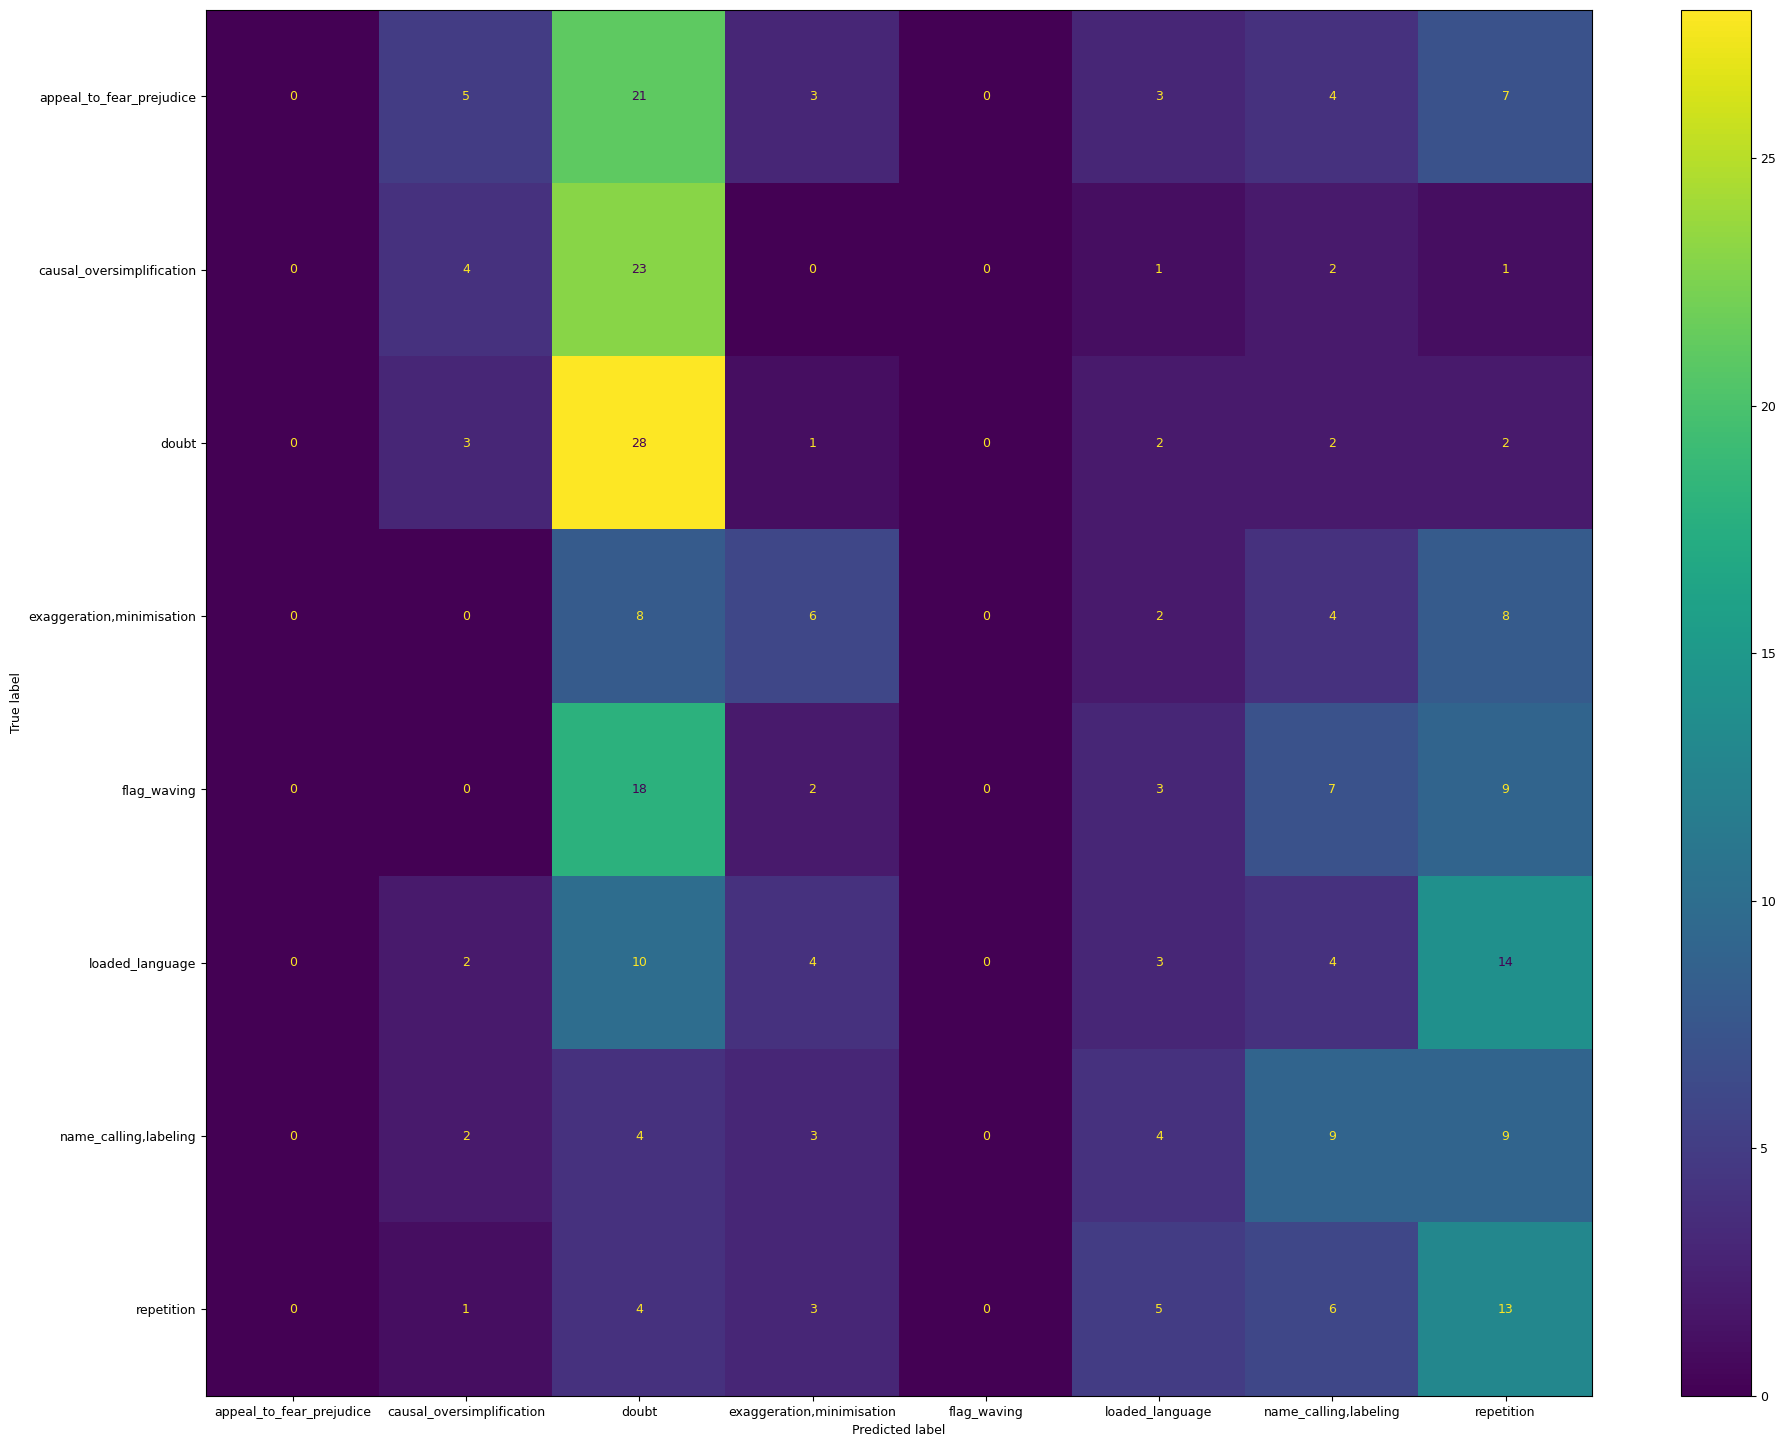

In [ ]:
misclassified, correctly_classified = evaluate_model(model, test_dataloader)

## Hyper-parameter tuning

In [ ]:
import itertools
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search(X_train, y_train, X_val, y_val, max_length):
    best_result = None
    best_f1 = float('-inf')
    patience = 10

    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]
    batch_sizes = [32]
    num_layers = [1, 2, 3]
    learning_rate = [0.01,0.001,0.0001]

    total_combinations = len(dropouts) * len(weight_decays) * len(batch_sizes) * len(num_layers) * len(learning_rate)
    current_combination = 0

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    for do, wd, bs, nl,lr in itertools.product(dropouts, weight_decays, batch_sizes, num_layers, learning_rate):
        current_combination += 1
        # Create a model with the current hyperparameters
        model = LSTMClassifier(dropout=do, num_layers=nl).to(device)

        # Create dataloaders
        train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
        val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Train the model
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

        early_stopping_counter = 0
        best_val_f1 = -float('inf')

        for epoch in range(1000):
            model.train()
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model
            model.eval()
            val_predictions = []
            val_labels = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids)
                    predictions = torch.argmax(outputs, dim=1)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_result = {
                    'dropout': do,
                    'weight_decay': wd,
                    'num_layers': nl,
                    'learning_rate' : lr,
                    'batch_size': bs,
                    'f1': best_f1
                }
            if early_stopping_counter >= patience:
                progress = current_combination / total_combinations
                print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                break

            scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, max_length)

print("Best result:", result)

Progress: 1.23% | 1/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32, 'f1': 0.06047532315122901}
Progress: 2.47% | 2/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f1': 0.06104717737318219}
Progress: 3.70% | 3/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f1': 0.06104717737318219}
Progress: 4.94% | 4/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f1': 0.06104717737318219}
Progress: 6.17% | 5/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f1': 0.06104717737318219}
Progress: 7.41% | 6/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f

## Evaluate

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train(X_train, y_train, X_val, y_val, max_length, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMClassifier(dropout=best_params['dropout'], num_layers=best_params['num_layers']).to(device)

    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

    patience = 10
    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    for epoch in range(1000):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            break

        scheduler.step(val_f1)

    return model


def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []
    all_lengths = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            lengths = batch['length']

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_input_ids.extend(input_ids.cpu().numpy())
            all_lengths.extend(lengths)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted',zero_division=1)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    display_labels = [int_to_label[i] for i in sorted(int_to_label.keys())]
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)

    class_report = classification_report(all_labels, all_predictions, target_names=display_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

    # Visualize confusion matrix
    plt.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(23,18))
    cm_display.plot(ax=ax)

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]


    return misclassified, correctly_classified


In [ ]:
result = {'dropout': 0.2, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32}

best_model = train(X_train, y_train, X_val, y_val, max_length, result)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.0534
Precision: 0.2339
Recall: 0.0534
F1-score: 0.0055
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.00      0.00      0.00        31
                    doubt       0.00      0.00      0.00        38
exaggeration,minimisation       0.00      0.00      0.00        28
              flag_waving       0.00      0.00      0.00        39
          loaded_language       0.00      0.00      0.00        37
    name_calling,labeling       0.05      1.00      0.10        31
           not_propaganda       0.00      0.00      0.00       301
               repetition       0.00      0.00      0.00        32

                 accuracy                           0.05       580
                macro avg       0.01      0.11      0.01       580
             weighted avg       0.00      0.05      0.01       580



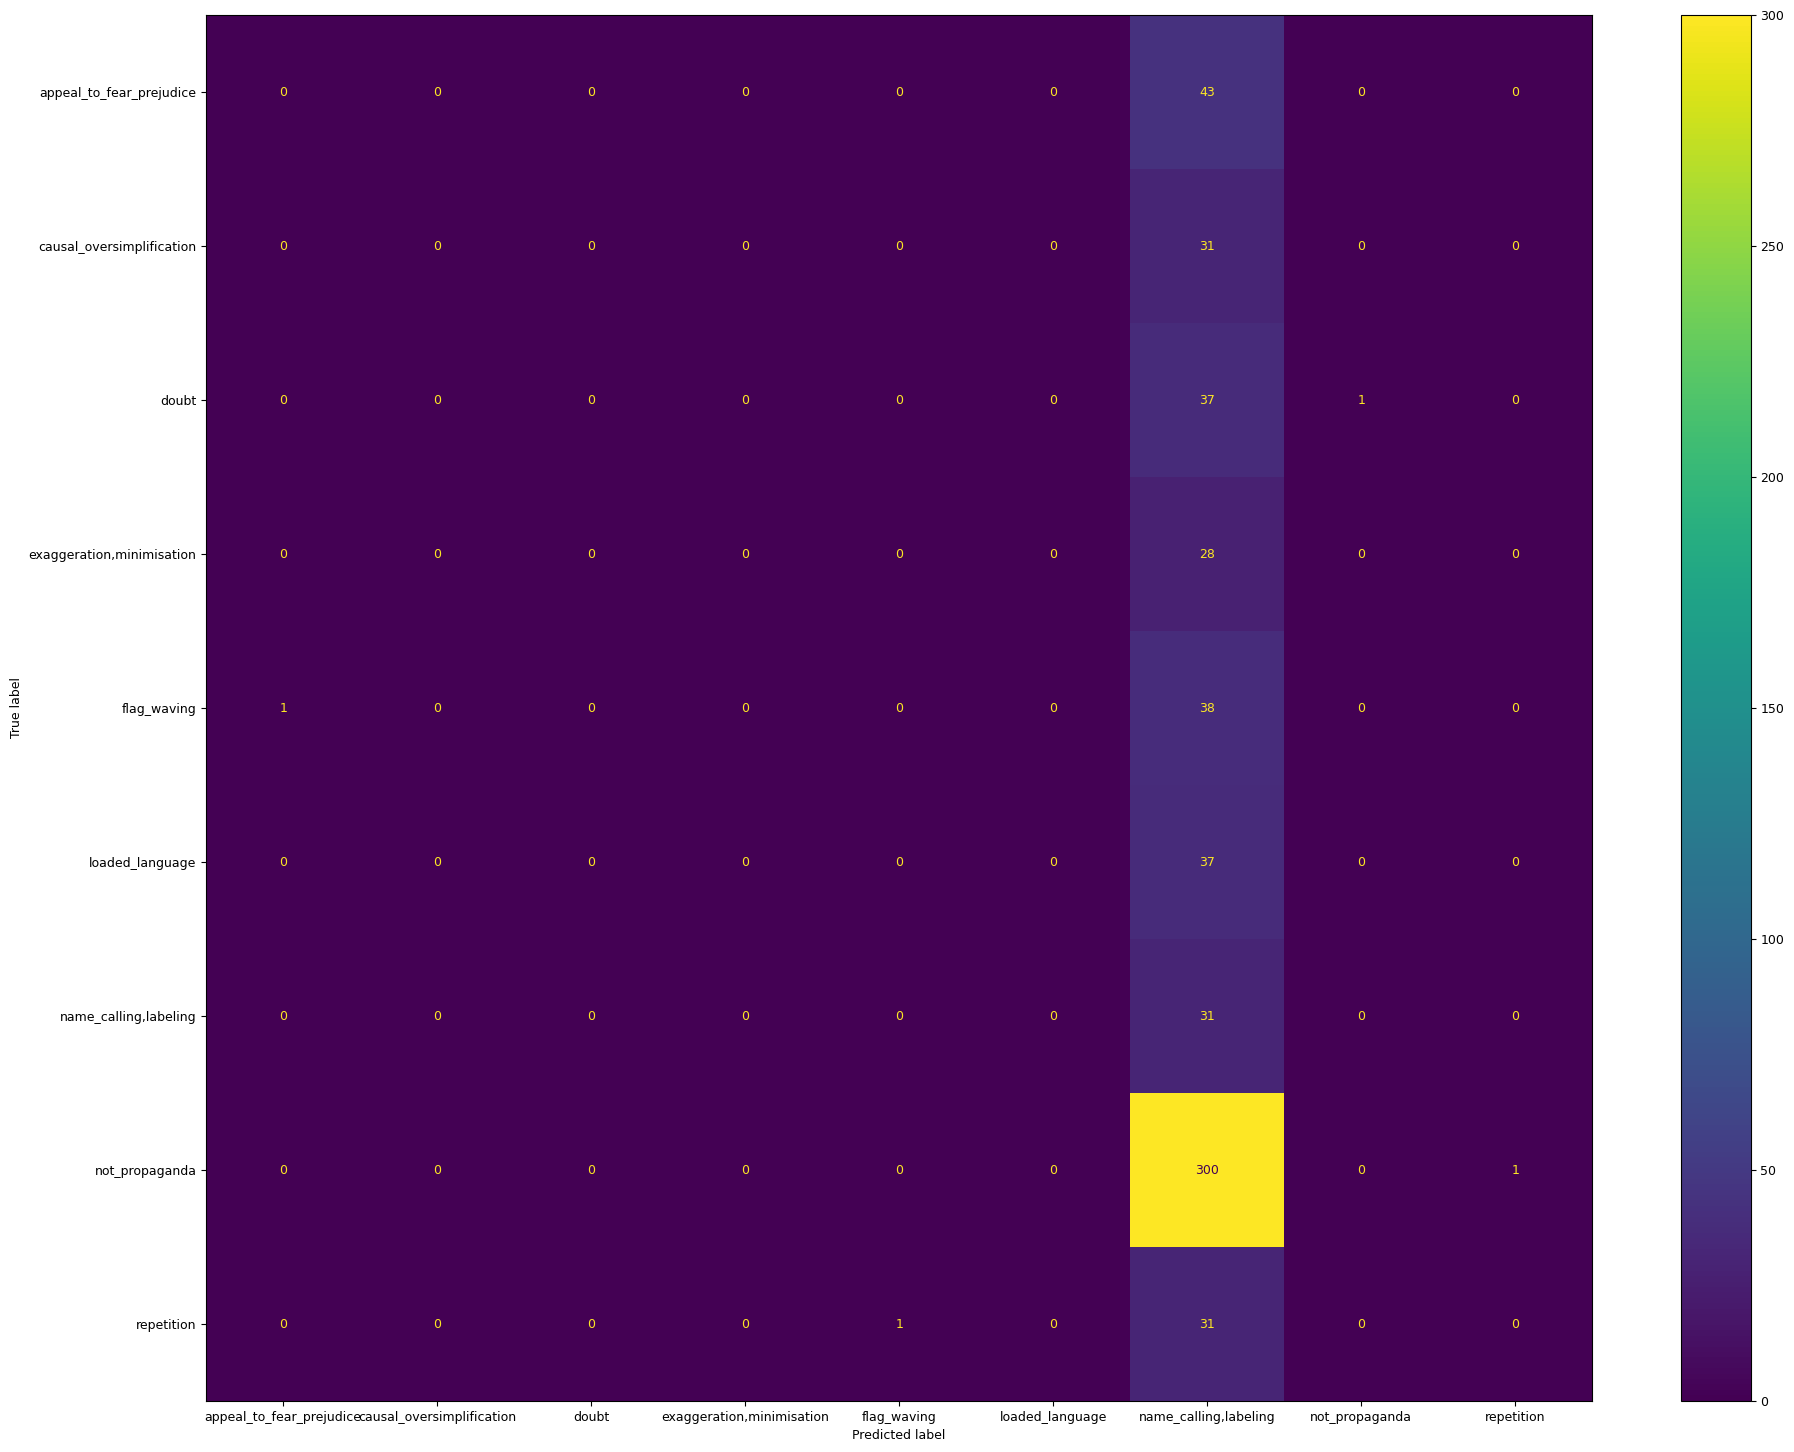

In [ ]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified,correctly_classified = evaluate_model(best_model, test_dataloader)

## Error Analysis

### Sentence length distribution

Test Set - Average Length: 28.91
misclassified - Average Length: 28.97, Maximum Length: 120
Correctly Classified - Average Length: 24.36, Minimum Length: 4


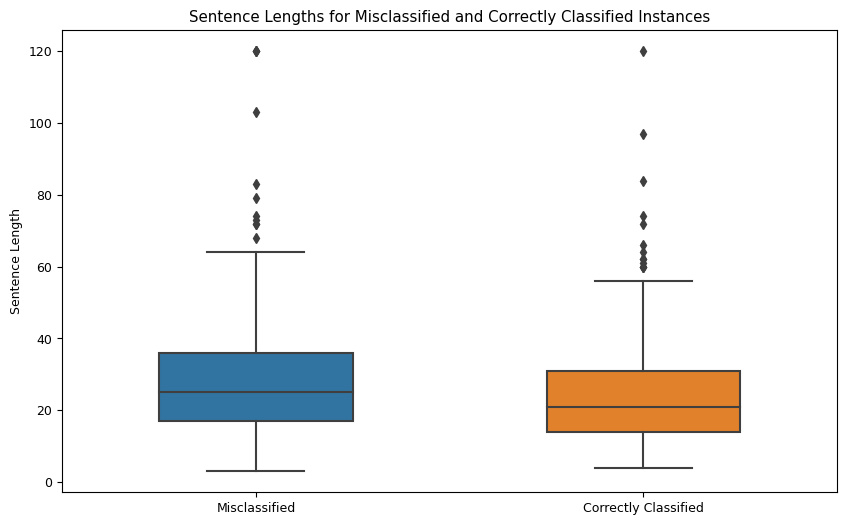

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get actual lengths of sentences for misclassified and correctly classified instances
misclassified_lengths = [length for _, _, _, length in misclassified]
correctly_classified_lengths = [length for _, _, _, length in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()


### Most frequent word

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in misclassified])
correctly_classified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in correctly_classified])

# Get the top 10 most frequent words and their sentence counts for each category
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

[nltk_data] Downloading package stopwords to /root/nltk_data...


Top 10 words in misclassified sentences with their sentence counts:
bos: 316 (in 303 sentences)
eos: 314 (in 303 sentences)
would: 23 (in 22 sentences)
trump: 21 (in 21 sentences)
said: 21 (in 21 sentences)
people: 19 (in 19 sentences)
world: 18 (in 17 sentences)
american: 18 (in 15 sentences)
us: 16 (in 16 sentences)
one: 16 (in 16 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
bos: 277 (in 277 sentences)
eos: 277 (in 277 sentences)
one: 23 (in 19 sentences)
said: 21 (in 19 sentences)
also: 15 (in 14 sentences)
may: 14 (in 14 sentences)
trump: 14 (in 13 sentences)
u: 13 (in 13 sentences)
right: 10 (in 9 sentences)
public: 10 (in 9 sentences)


[nltk_data]   Unzipping corpora/stopwords.zip.


### Grammartical sturucture analysis

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
nmod: 82529
pobj: 1066
prep: 928
punct: 898
det: 815
nsubj: 778
compound: 654
dobj: 578
amod: 445
aux: 407

Top 10 grammatical constructs in correctly classified sentences:
nmod: 79105
pobj: 815
punct: 811
prep: 741
nsubj: 622
det: 606
compound: 595
dobj: 415
amod: 338
ROOT: 296


# Bidirectional+ Word embedding method (glove)

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file_path = "glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_file_path)

In [7]:
vocab_size = 10000
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Baseline

In [8]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.sentences_seq = self.tokenizer.texts_to_sequences(self.sentences)
        self.sentences_padded = pad_sequences(self.sentences_seq, maxlen=self.max_length, padding='post', truncating='post')
        self.lengths = [min(len(seq), max_length) for seq in self.sentences_seq]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences_padded[idx]
        label = self.labels[idx]
        length = self.lengths[idx]

        return {
            'input_ids': torch.tensor(sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'length': length
        }

In [9]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=1000, hidden_dim=1000, num_classes=8, num_layers=1, dropout=0.1, embedding_matrix=None):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_out = self.dropout(lstm_out[:, -1, :])
        linear_out = self.fc(pooled_out)
        final_out = self.softmax(linear_out)

        return final_out

In [10]:
max_length = 140
vocab_size = 10000
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the LSTM model's embedding layer with the embedding matrix
model = LSTMClassifier(vocab_size=vocab_size, embedding_dim=300,embedding_matrix=embedding_matrix)
model.to(device)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

patience = 10
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(1000):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

<ipython-input-13-7c455d4faf77>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


Epoch: 1, Validation F1: 0.03038395347457124
Epoch: 2, Validation F1: 0.02670464660850988
Epoch: 3, Validation F1: 0.03038395347457124
Epoch: 4, Validation F1: 0.01468268414027424
Epoch: 5, Validation F1: 0.01468268414027424
Epoch: 6, Validation F1: 0.01468268414027424
Epoch: 7, Validation F1: 0.0458032749341578
Epoch: 8, Validation F1: 0.01468268414027424
Epoch: 9, Validation F1: 0.01468268414027424
Epoch: 10, Validation F1: 0.023433763749402203
Epoch: 11, Validation F1: 0.030163779898668554
Epoch: 12, Validation F1: 0.0458032749341578
Epoch: 13, Validation F1: 0.030163779898668554
Epoch: 14, Validation F1: 0.01468268414027424
Epoch: 15, Validation F1: 0.0458032749341578
Epoch: 16, Validation F1: 0.02670464660850988
Epoch: 17, Validation F1: 0.01468268414027424
Early stopping triggered.
Accuracy: 0.13978494623655913
Precision: 0.01953983119435773
Recall: 0.13978494623655913
F1-score: 0.03428687360519375


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.1398
Precision: 0.8798
Recall: 0.1398
F1-score: 0.0343
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.00      0.00      0.00        31
                    doubt       0.00      0.00      0.00        38
exaggeration,minimisation       0.00      0.00      0.00        28
              flag_waving       0.14      1.00      0.25        39
          loaded_language       0.00      0.00      0.00        37
    name_calling,labeling       0.00      0.00      0.00        31
               repetition       0.00      0.00      0.00        32

                 accuracy                           0.14       279
                macro avg       0.02      0.12      0.03       279
             weighted avg       0.02      0.14      0.03       279



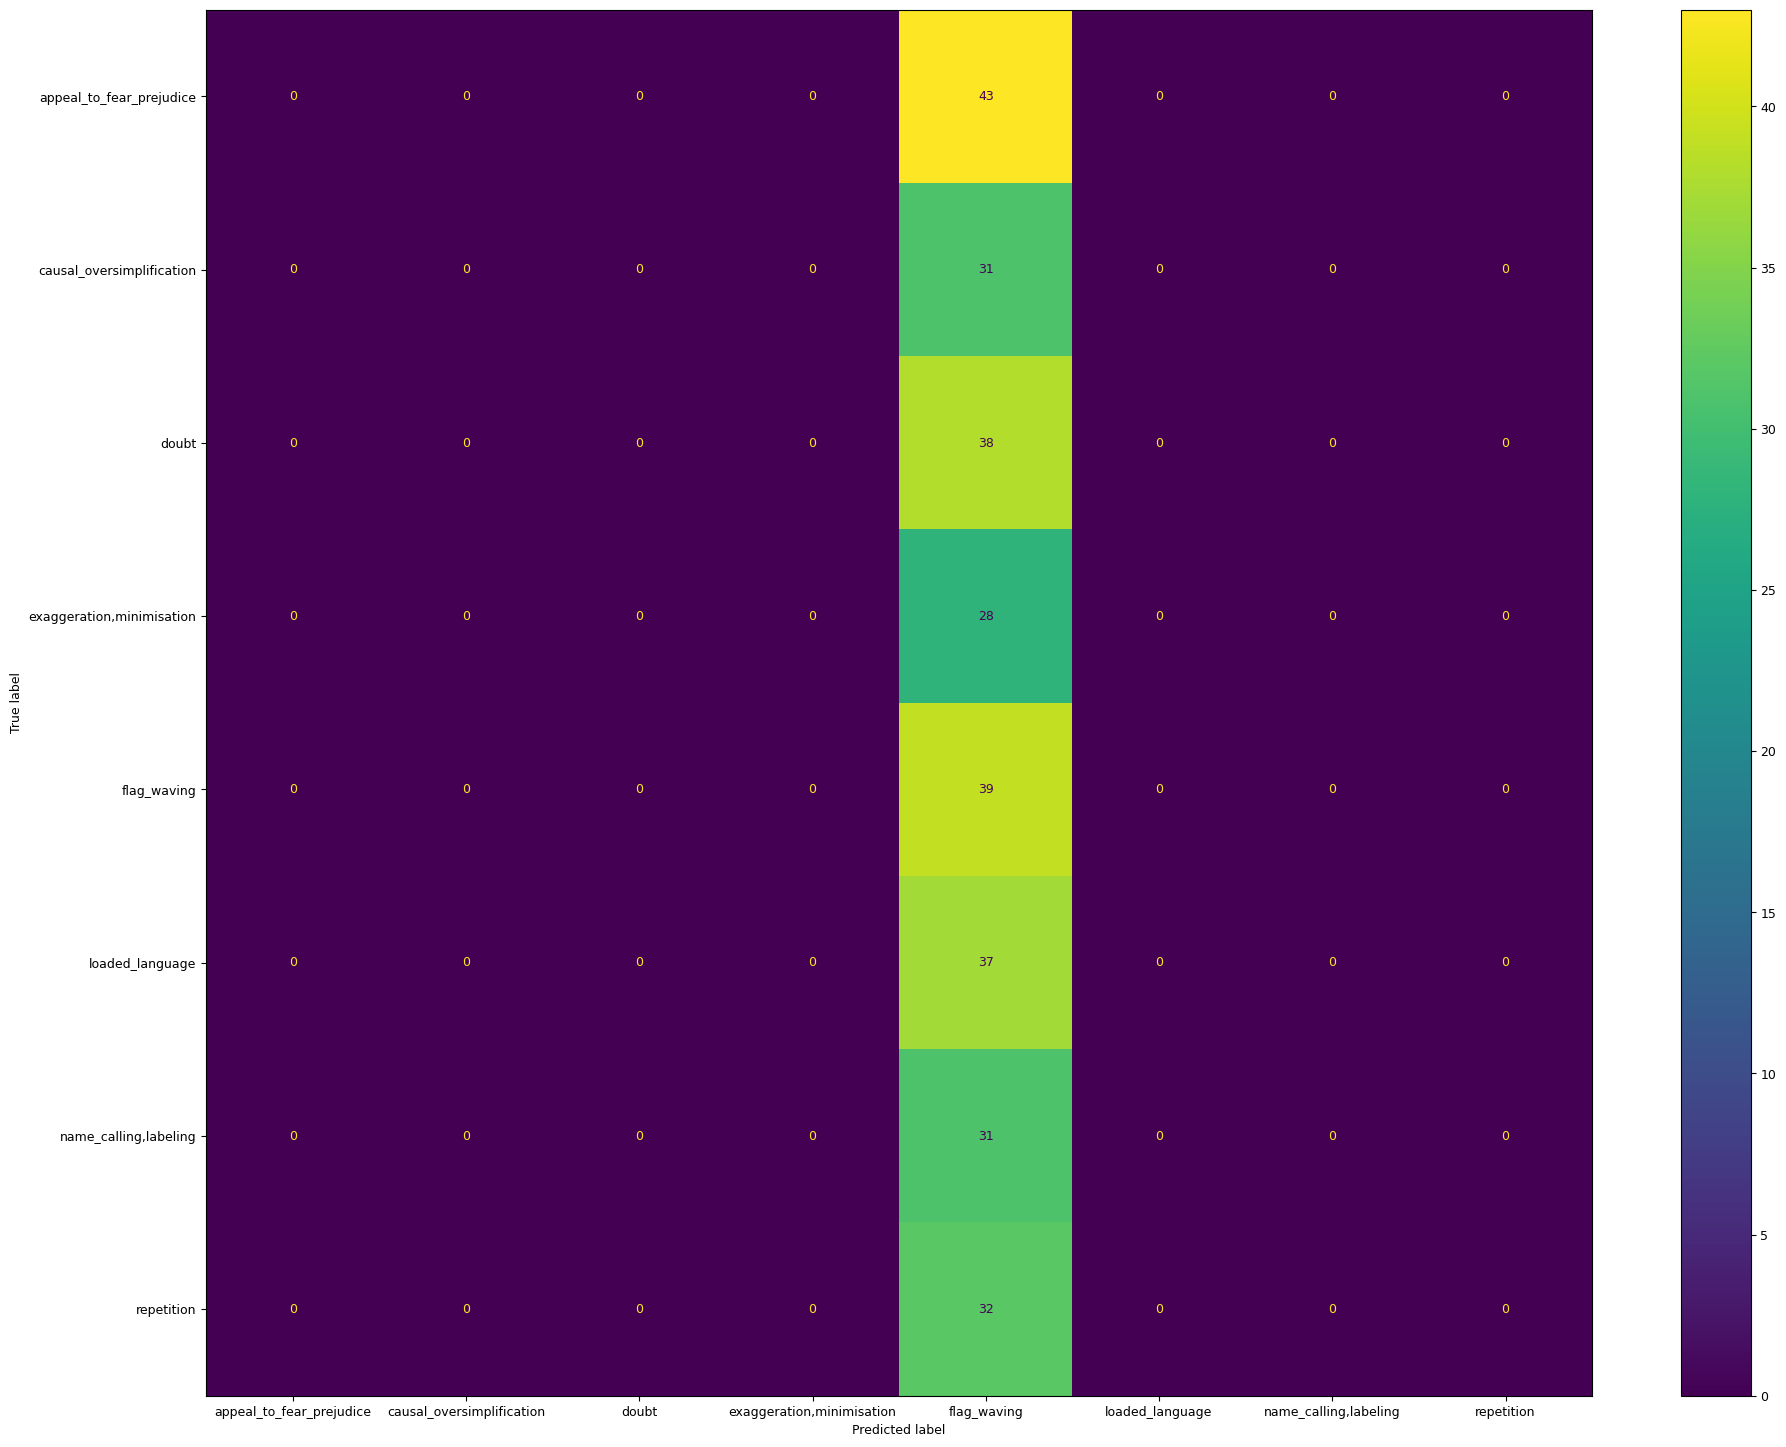

In [ ]:
misclassified, correctly_classified = evaluate_model(model, test_dataloader)

## Hyper-parameter tuning

In [13]:
import itertools
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search(X_train, y_train, X_val, y_val, max_length):
    best_result = None
    best_f1 = float('-inf')
    patience = 10

    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]
    batch_sizes = [32]
    num_layers = [1, 2, 3]
    learning_rate = [0.01,0.001,0.0001]

    total_combinations = len(dropouts) * len(weight_decays) * len(batch_sizes) * len(num_layers) * len(learning_rate)
    current_combination = 0

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    for do, wd, bs, nl,lr in itertools.product(dropouts, weight_decays, batch_sizes, num_layers, learning_rate):
        current_combination += 1
        # Create a model with the current hyperparameters
        model = LSTMClassifier(dropout=do, num_layers=nl).to(device)

        # Create dataloaders
        train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
        val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Train the model
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

        early_stopping_counter = 0
        best_val_f1 = -float('inf')

        for epoch in range(1000):
            model.train()
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model
            model.eval()
            val_predictions = []
            val_labels = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids)
                    predictions = torch.argmax(outputs, dim=1)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted',zero_division=1)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_result = {
                    'dropout': do,
                    'weight_decay': wd,
                    'num_layers': nl,
                    'learning_rate' : lr,
                    'batch_size': bs,
                    'f1': best_f1
                }
            if early_stopping_counter >= patience:
                progress = current_combination / total_combinations
                print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                break

            scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, max_length)

print("Best result:", result)

Progress: 1.23% | 1/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32, 'f1': 0.0458032749341578}
Progress: 2.47% | 2/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'f1': 0.045869822618976965}
Progress: 3.70% | 3/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'f1': 0.04612812085567664}
Progress: 4.94% | 4/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'f1': 0.04612812085567664}
Progress: 6.17% | 5/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'f1': 0.04612812085567664}
Progress: 7.41% | 6/81 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 32

## Evaluate

In [18]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(X_train, y_train, X_val, y_val, max_length, best_params, vocab_size, embedding_matrix):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMClassifier(dropout=best_params['dropout'], 
                           num_layers=best_params['num_layers'], 
                           vocab_size=vocab_size,
                           embedding_dim=300, 
                           embedding_matrix=embedding_matrix).to(device)
    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    loss_fn = torch.nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

    patience = 10
    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    for epoch in range(1000):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            break

        scheduler.step(val_f1)

    return model


def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []
    all_lengths = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            lengths = batch['length']

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_input_ids.extend(input_ids.cpu().numpy())
            all_lengths.extend(lengths)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted',zero_division=1)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    display_labels = [int_to_label[i] for i in sorted(int_to_label.keys())]
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)

    class_report = classification_report(all_labels, all_predictions, target_names=display_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

    # Visualize confusion matrix
    plt.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(23,18))
    cm_display.plot(ax=ax)

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]


    return misclassified, correctly_classified

In [19]:
result = {'dropout': 0.3, 'weight_decay': 0.001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32}
best_model = train(X_train, y_train, X_val, y_val, max_length, result, vocab_size, embedding_matrix)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.1398
Precision: 0.8798
Recall: 0.1398
F1-score: 0.0343
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.00      0.00      0.00        31
                    doubt       0.00      0.00      0.00        38
exaggeration,minimisation       0.00      0.00      0.00        28
              flag_waving       0.14      1.00      0.25        39
          loaded_language       0.00      0.00      0.00        37
    name_calling,labeling       0.00      0.00      0.00        31
               repetition       0.00      0.00      0.00        32

                 accuracy                           0.14       279
                macro avg       0.02      0.12      0.03       279
             weighted avg       0.02      0.14      0.03       279



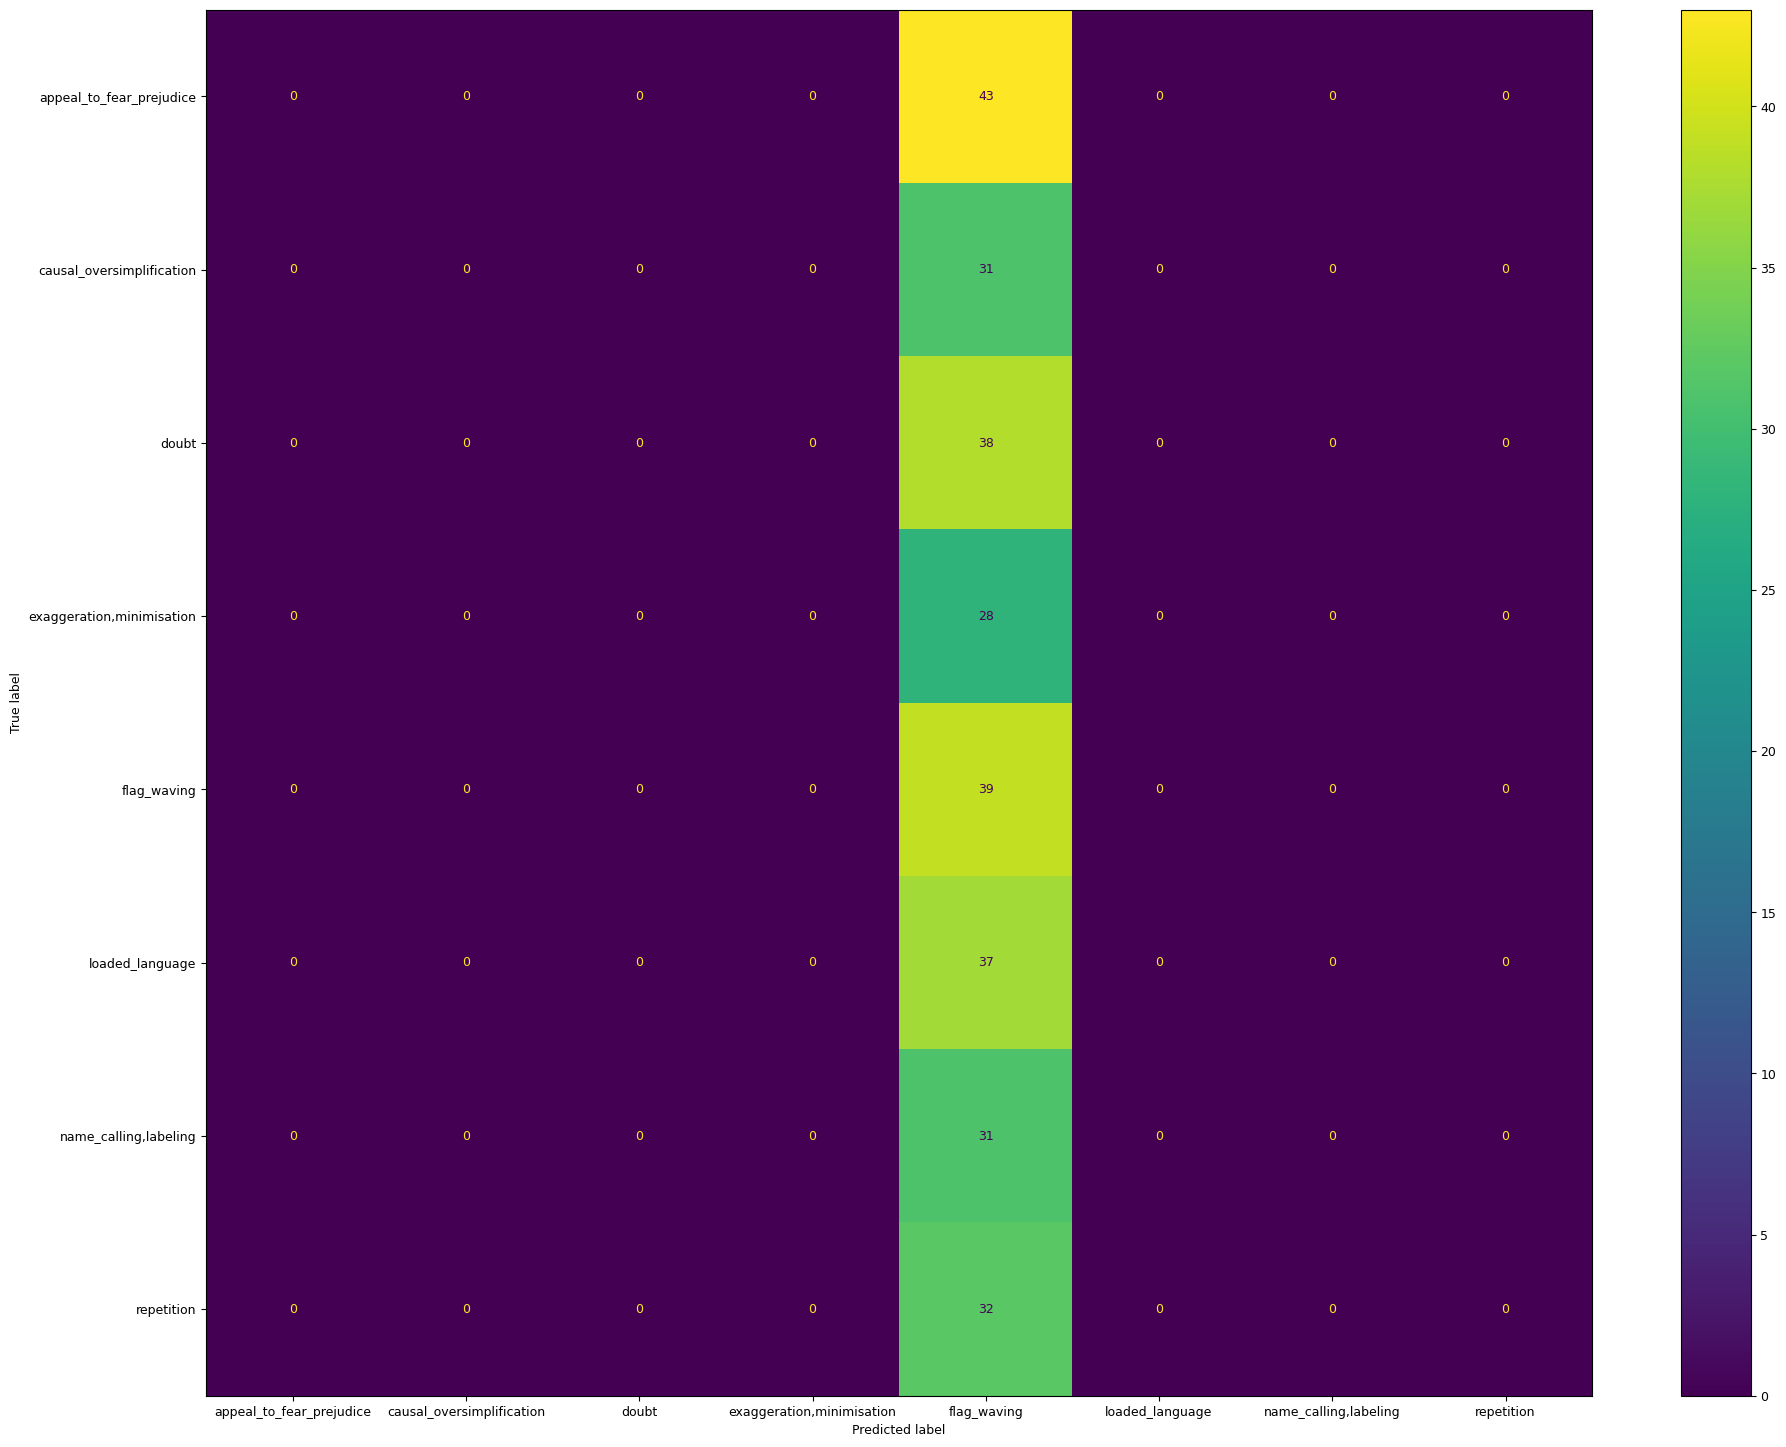

In [20]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified,correctly_classified = evaluate_model(best_model, test_dataloader)

## Error Analysis

### Sentence length distribution

Test Set - Average Length: 31.95
misclassified - Average Length: 30.81, Maximum Length: 140
Correctly Classified - Average Length: 32.62, Minimum Length: 12


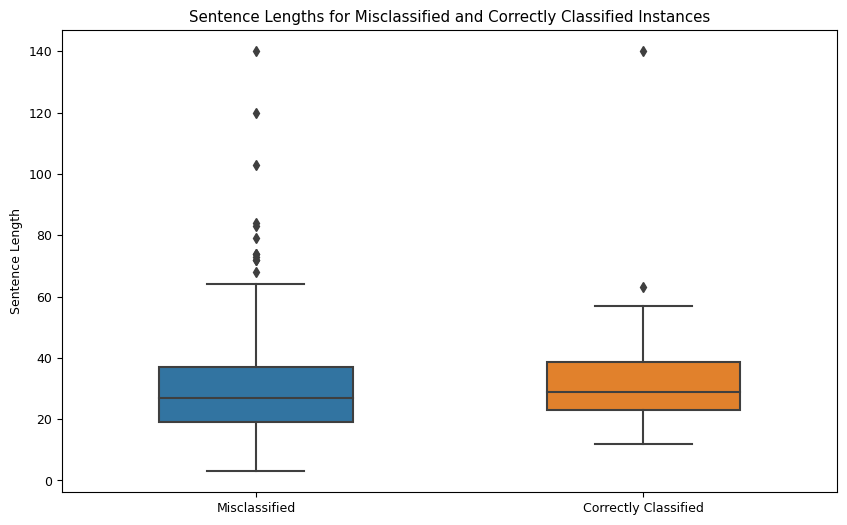

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get actual lengths of sentences for misclassified and correctly classified instances
misclassified_lengths = [length for _, _, _, length in misclassified]
correctly_classified_lengths = [length for _, _, _, length in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()


### Most frequent word

In [22]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in misclassified])
correctly_classified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in correctly_classified])

# Get the top 10 most frequent words and their sentence counts for each category
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

Top 10 words in misclassified sentences with their sentence counts:
bos: 245 (in 240 sentences)
eos: 245 (in 240 sentences)
trump: 23 (in 22 sentences)
one: 19 (in 18 sentences)
would: 18 (in 17 sentences)
world: 17 (in 16 sentences)
said: 14 (in 14 sentences)
many: 12 (in 11 sentences)
us: 12 (in 12 sentences)
even: 12 (in 11 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
bos: 44 (in 39 sentences)
eos: 43 (in 39 sentences)
american: 12 (in 10 sentences)
trump: 7 (in 7 sentences)
people: 7 (in 7 sentences)
america: 5 (in 5 sentences)
put: 5 (in 5 sentences)
time: 4 (in 4 sentences)
public: 4 (in 4 sentences)
would: 4 (in 4 sentences)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Grammartical sturucture analysis

In [23]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
nmod: 78671
pobj: 949
punct: 791
prep: 788
det: 710
nsubj: 668
compound: 511
dobj: 470
amod: 357
aux: 319

Top 10 grammatical constructs in correctly classified sentences:
nmod: 12516
pobj: 158
prep: 130
punct: 129
nsubj: 107
det: 107
compound: 103
dobj: 92
amod: 67
aux: 59
